# ANALYZE EXPERIMENTS

In [1]:
import smarte.constants as cn
import smarte as smt

import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
from io import StringIO
import zipfile

# Helpers

# Data Overview

In [2]:
PROVIDER = smt.ExperimentProvider()
DF = PROVIDER.df
DF.head()

,biomodel_num,columns_deleted,max_fev,method,noise_mag,latincube_idx,range_min_frac,range_max_frac,ts_instance,index,num_species,num_reaction,num_parameter,median_err,max_err,min_err,rssq,avg_time,cnt,tot_time
0,1,0,1000,differential_evolution,0.1,1,0.5,2.0,1,0.0,12.0,17.0,35.0,0.183709,0.999112,-0.020618,2.141837e-07,0.000195,1001.0,0.195356
1,1,0,1000,differential_evolution,0.1,1,0.5,2.0,2,0.0,12.0,17.0,35.0,0.418409,-0.997113,-0.022271,2.168168e-07,0.000198,1001.0,0.197768
2,1,0,1000,differential_evolution,0.1,1,0.5,2.0,3,0.0,12.0,17.0,35.0,0.224564,1.000000,0.093372,2.156352e-07,0.000177,1001.0,0.177638
3,1,0,1000,differential_evolution,0.1,1,0.5,2.0,4,0.0,12.0,17.0,35.0,0.237401,0.999966,0.039410,2.138009e-07,0.000178,1001.0,0.178542
4,1,0,1000,differential_evolution,0.1,1,0.5,2.0,5,0.0,12.0,17.0,35.0,0.237401,0.999966,0.039410,2.147728e-07,0.000196,1001.0,0.196658


In [3]:
len(DF)

239305

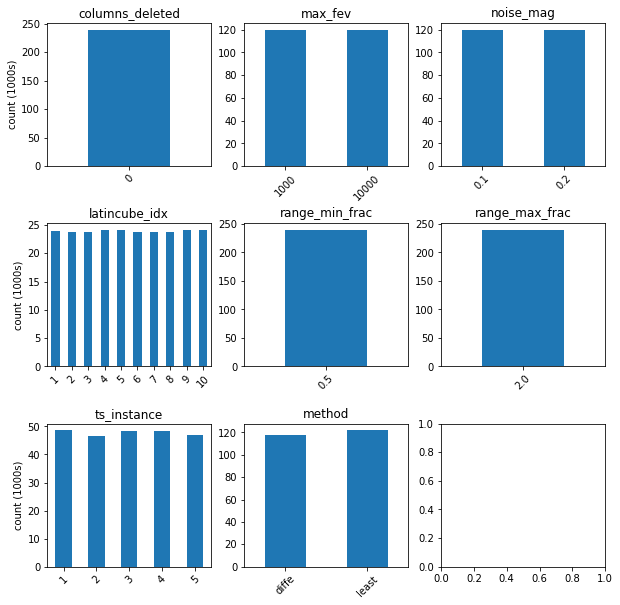

In [4]:
PROVIDER.plotFactorCounts()

# Missing Experiments

In [ ]:
set(["--".join(w.calcMultivaluedFactors()) for w in workunits])

In [ ]:
# Find what varies across workunits

In [ ]:
# Combine workunits
agg_workunits = smt.ExtendedDict({k: [] for k in cn.SD_CONDITIONS})
for workunit in workunits[1:]:
    dct = workunit.removeExpansions()
    for key in dct.keys():
        # Handle bug where get [["differential_evolution"]]
        if isinstance(dct[key], str):
            values = set(agg_workunits[key]).union(dct[key])
        elif isinstance(dct[key], list):
            values = set(agg_workunits[key]).union(dct[key][0])
        agg_workunits[key] = list(values)
    print(agg_workunits)
if False:
    # Remove those known to vary
    for factor in [cn.SD_BIOMODEL_NUM, cn.SD_TS_INSTANCE]:
        del agg_workunits[factor]
    str(agg_workunits)

In [ ]:
count_df = pd.DataFrame(DF.groupby([cn.SD_NOISE_MAG, cn.SD_METHOD, cn.SD_MAX_FEV]).count()["biomodel_num"])
count_df = count_df.rename(columns={"biomodel_num": "num_experiments"})
pd.DataFrame(count_df)

In [ ]:
dff = DF[[cn.SD_NOISE_MAG, cn.SD_RANGE_INITIAL_FRAC, cn.SD_METHOD]]
len(dff)

In [ ]:
DF.columns

In [ ]:
DF[DF[cn.SD_NUM_PARAMETER] > 400]

# Analyze variability by replication

In [ ]:
dfg = DF.groupby(cn.SD_BIOMODEL_NUM)
mean_df = pd.DataFrame(dfg.mean().compute())
std_df = pd.DataFrame(dfg.std().compute())
cv_df = pd.DataFrame(cnt_std/cnt_mean)

In [ ]:
plt.hist(cv_df[cn.SD_CNT])
_ = plt.title("CV of Count of Function Evaluations")

In [ ]:
_ = plt.hist(mean_df[cn.SD_CNT], bins=100, cumulative=True, density=True)
_ = plt.title("Mean Number of Function Evaluations")

In [ ]:
_ = plt.hist(mean_df[cn.SD_MEDIAN_ERR], bins=100, cumulative=True, density=True)
_ = plt.title("Median Log2 Actual/True")

In [ ]:
plt.scatter(mean_df[cn.SD_MEDIAN_ERR], mean_df[cn.SD_CNT])
plt.xlabel("median err")
plt.ylabel("function evaluations")